In [54]:
# Importing the libraries
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import math
import pdb
import numpy.polynomial.polynomial as poly

from scipy import linalg

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

We need the alphas to have large values

In [7]:
def image_generator(K, supp):
    """ Generating the signal model parameters
    Input:
        K: the number of delta functions
        supp: the support of the points
    Output:
        x: location of the point sources
        alpha: the weights corresponding to each point source
    """
    X = (np.random.rand(2, K)-0.5)*supp
    alpha = 10.*np.random.rand(K, 1)

    return X, alpha

In [8]:
def feature_generator(X, alpha, r):

    K = np.shape(X)[1]
    o_dist = np.linalg.norm(X, axis=0)

    p1_x = np.tile(np.expand_dims(X[0, :], axis=1), (1, K))
    p2_x = np.tile(X[0, :], (K, 1))

    p1_y = np.tile(np.expand_dims(X[1, :], axis=1), (1, K))
    p2_y = np.tile(X[1, :], (K, 1))

    p_dist = np.sqrt(np.square(p1_x - p2_x) + np.square(p1_y - p2_y))

    # generating features
    mu = np.zeros((len(r), 1))
    C = np.zeros((len(r), 1))
    for k1 in range(K):
        mu = mu + alpha[k1] * \
            special.jv(0, np.expand_dims(r, axis=1) * o_dist[k1])
        for k2 in range(K):
            C = C + alpha[k1] * alpha[k2] * \
                special.jv(0, np.expand_dims(r, axis=1) * p_dist[k1, k2])

    return mu, C, o_dist, p_dist

In [9]:
def disc_feature_gen(x, alpha, dist, delta, N_d, feature):
    """ In this feature, we assume that the effect of the Fourier transform of the Bessel function has been cancelled.
    """
    
    K = len(alpha)
    Y = np.zeros((1,len(x)))

    if (feature=="mean"):
        for k in range(K):
            Y = Y + alpha[k]*np.exp(-2j*math.pi*np.square(delta*dist[k])*(x+0.0)/N_d)
    elif (feature=="cov"):
        for k1 in range(K):
            for k2 in range(K):
                Y = Y + alpha[k1]*alpha[k2]*np.exp(-2j*math.pi*np.square(delta*dist[k1,k2])*x/N_d)

    return Y

# Forming the equations used by the prony method

Functions that are used for implementing the prony method.
Let $y$ denote the discrete signal that is a sum of several harmonics.
\begin{align}
x[m] = \sum\limits_{k=1}^{K} \alpha_k e^{-j \frac{2 \pi}{N} m t_k}
\end{align}
where $t_k$ and $\alpha_k$s correspond to the frequency of the harmonics and their weights. Note that the above form suggests that $y$ is a solution of a discrete differential equation written as,
\begin{align}
x[n]+b_1x[n-1]+b_2 x[n-2]+...+b_K x[n-K] = 0 \\
b_1x[n-1]+b_2 x[n-2]+...+b_K x[n-K] = -x[n]
\end{align}
Indeed, we can write the above equation for $n \in \{K, \cdots, M-1\}$ where $M \geq 2K$ and then assemble the set of equations as a matrix vector form.
To implement the prony method, we construct the following matrix:

\begin{equation}
  \begin{bmatrix}
    x[K-1] & x[K-2] & \cdots & x[0] \\
    x[K] & x[K-1] & \cdots & x[1] \\
    x[K+1] & x[K] & \cdots & x[2] \\
    \vdots & \vdots & \cdots & \vdots \\
    x[M-2] & x[M-3] & \cdots & x[M-1] \\
  \end{bmatrix}
  \begin{bmatrix}
    b_1 \\
    b_2 \\
    b_3 \\
    \vdots \\
    b_K
  \end{bmatrix} = -
  \begin{bmatrix}
    x[K] \\
    x[K+1] \\
    x[K+2] \\
    \vdots \\
    x[M-1] \\
  \end{bmatrix}
\end{equation}
In the origibal prony method, $M = 2K$. However, with more noise and error in the model, it would be better to have more equations, i.e. larger $M$. When $M>2k$ and the above equation is solved via LS, the method is called extended prony. 
Note that after solving the above equation and deriving $b$, the $K$ roots of the following equation mark the harmonics,
\begin{align}
b_1 z^{-1}+b_2 z^{-2}+...+b_K z^{-K} = -1
\end{align}

In [10]:
# generates the vector and the matrix based on the above form
def extended_prony_matrix(K, M, alpha, dist, delta, feature):
   
    tmp = np.arange(4*M)
    prony_mat = np.zeros((M-K,K),dtype=complex)
    prony_vec = np.zeros((M-K,1),dtype=complex)
    # we dont want to include the sample at 0 because that points to the non-singularity of the feature
    for k1 in range(M-K):
        if (k1 == 0):
            prony_mat[k1,:] = disc_feature_gen(tmp[K-1::-1],alpha,dist,delta,M,feature)
        else:
            prony_mat[k1,:] = disc_feature_gen(tmp[k1+K-1:k1-1:-1],alpha,dist,delta,M, feature)
        prony_vec[k1,0] = -disc_feature_gen(np.array([k1+K]),alpha,dist,delta,M,feature)

    return prony_mat, prony_vec

In general, there is no guarantee that the roots derived from the polynomial equation are all complex exponentials. To further impose this, one can say that if $g$ is a root of the polynomial equation, then $\frac{1}{\overline{g}}$ would also be (note that this is not exactly the same constraint as having complex exponential roots, but still it is helpful). By considering this fact, it is possible to add more equations to the above system. Finally, we will have,

\begin{equation}
   \begin{bmatrix}
    x[K-1] & x[K-2] & \cdots & x[0] \\
    x[K] & x[K-1] & \cdots & x[1] \\
    x[K+1] & x[K] & \cdots & x[2] \\
    \vdots & \vdots & \cdots & \vdots \\
    x[M-2] & x[M-3] & \cdots & x[M-1] \\
    \overline{x}[1] & \overline{x}[2] & \cdots & \overline{x}[K] \\
    \overline{x}[2] & \overline{x}[3] & \cdots & \overline{x}[K+1] \\
    \vdots & \vdots & \cdots & \vdots \\
    \overline{x}[M-K] & \overline{x}[M-K+1] & \cdots & \overline{x}[M-1] \\
  \end{bmatrix}
  \begin{bmatrix}
    b_1 \\
    b_2 \\
    b_3 \\
    \vdots \\
    b_K
  \end{bmatrix} = -
  \begin{bmatrix}
    x[K] \\
    x[K+1] \\
    x[K+2] \\
    \vdots \\
    x[M-1] \\
    \overline{x}[0] \\
    \vdots \\
    \overline{x}[M-K-1] \\
  \end{bmatrix}
\end{equation}
Solving the above equations is called forward-backward prony method.

In [11]:
def forward_backward_prony_matrix(K, M, alpha, dist, delta,feature):
    
    tmp = np.arange(4*M)
    # generating the half of the matrix and vector
    prony_mat1, prony_vec1 = extended_prony_matrix(K, M, alpha, dist, delta, feature)
    prony_mat2 = np.zeros((M-K,K),dtype=complex)
    prony_vec2 = np.zeros((M-K,1),dtype=complex)
    # we dont want to include the sample at 0 because that points to the non-singularity of the feature
    for k in range(M-K):
        # pdb.set_trace()
        prony_mat2[k,:] = disc_feature_gen(tmp[k+1:k+K+1], alpha, dist, delta, M, feature)
        prony_vec2[k,0] = -disc_feature_gen(np.array([k]),alpha, dist,delta,M,feature)
    
    prony_mat = np.concatenate((prony_mat1, np.conj(prony_mat2)),axis = 0)
    prony_vec = np.concatenate((prony_vec1, np.conj(prony_vec2)),axis=0)

    return prony_mat, prony_vec

# Finding the weights and relabeling the distances

When the harmonics are extracted, they are unlabeled. Thus, although we know the weights corresponding to each atom, we don't know the labels for the extracted geometry information. Thus, it is possible to recalculate these weights in order to find the labels corresponding to the distance information.

In [12]:
def weight_mat_gen(K,harm,alpha,dist,delta,M,feature):
    
    reshaped_harm = harm.reshape(1,-1)[0]
    weight_mat = np.zeros((K,K),dtype=complex)
    weight_vec = np.zeros((K,1),dtype=complex)
    r = np.arange(K)
    for k in range(K):
        weight_mat[k,:] = np.power(reshaped_harm,k)
        weight_vec[k,0] = disc_feature_gen(np.array([k]),alpha,dist,delta,M,feature)

    return weight_mat, weight_vec

In [13]:
def lin_con_gen(K):
   
    sz = K*(K-1)/2
    G = np.zeros((sz*2,sz**2))
    for k in range(sz):
        G[k,sz*k:sz*(k+1)] = 1
        G[k+sz,k:k+sz*(sz-1)+1:sz] = 1

    return G

In [14]:
def opt_objective(x,alpha_o,alpha_p):
    #pdb.set_trace()
    K = int(np.sqrt(len(x)))
    x = np.reshape(x,[K,K])
    cost = np.linalg.norm(x.dot(alpha_p)-alpha_o,ord=2)

    return cost

In [15]:
def cons_i(x,i,G):
    return G[i,:].dot(x)-1.

In [16]:
def dist_finder(harm, M):
    
    angles = -np.angle(harm)
    angles[angles<0] = 2*math.pi+angles[angles<0]
    angles = angles*M/(2*math.pi)
    dist = np.sqrt(angles)
    
    return dist

## Notes on the choice of parameters

$K$ and $supp$: If a large number of points are distributed in a small support, then their distances from the origin alongside their pairwise distances will be close. This results in a numerically low rank prony matrix. Right now in the codes, I am justing taking pinv in order to solve the linear system. We might also consider singular value filtering in order to avoid the ill-posed behavior of the prony matrix. 

$delta$: somehow corresponds to the sampling step of the projection lines.

$M, \widetilde{M}$: This is related to the number of equations used in the prony method. I have also set this value to be the number of FFT points, when taking FFT from the fourier transform of the mean and the covariance respectively.

We should set $M$ in order to avoid the ambiguity in the recovery of the distances. For this purpose we require,
\begin{align}
& max(\{r^2_i\}) \leq M \Rightarrow max(\{r^2_i\}) \leq \frac{{supp}^2}{4} \leq M \\
& max(\{d^2_{i,j}\}) \leq \widetilde{M} \Rightarrow max(\{d^2_{i,j}\}) \leq (\frac{\sqrt{2} supp}{2})^2 \leq \widetilde{M} \Rightarrow \frac{{supp}^2}{2} \leq \widetilde{M}
\end{align}


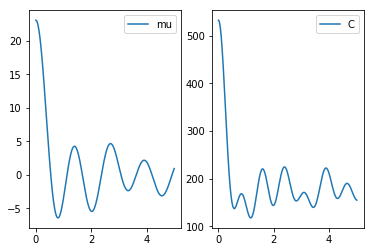

In [130]:
K = 4
supp = 10
num_points = 1000
X, alpha = image_generator(K, supp)
# X /= 20.
r = np.linspace(0.0, (supp+0.0) / 2, num=num_points)

delta = 1
M = int(np.ceil(np.square(supp)/1))
# feature estimation
mu, C, o_dist, p_dist = feature_generator(X*1, alpha, r)

# plotting the features
plt.figure()
plt.subplot(121)
plt.plot(r, mu, label='mu')
plt.legend()
plt.subplot(122)
plt.plot(r, C, label='C')
plt.legend()

[ 9.05350917 17.81827968  2.82726718 15.12631437]
[0.09053509 0.1781828  0.02827267 0.15126314]


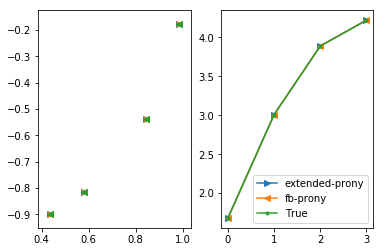

In [59]:
# Finding the distances from the origin based on the first order moment

feature = "mean"
prony_mat, prony_vec  = extended_prony_matrix(K, M, alpha, o_dist, delta, feature)
A = np.linalg.pinv(prony_mat).dot(prony_vec)
A = np.concatenate((np.array([[1]]),A),axis=0)

# finding the roots
harm_o= np.roots(tuple(A.reshape(1,-1)[0]))
true_harm_o = np.exp(-2j*math.pi*np.square(delta*o_dist)/(M))
    
# using forward_backward prony matrix
prony_mat_f, prony_vec_f = forward_backward_prony_matrix(K, M, alpha, o_dist, delta, feature)
B = np.linalg.pinv(prony_mat_f).dot(prony_vec_f)
B = np.concatenate((np.array([[1]]),B),axis=0)
harm_fo = np.roots(tuple(B.reshape(1,-1)[0]))

# recovering the distances from origin
dist_extended_prony = dist_finder(harm_o, M)
dist_fb_prony = dist_finder(harm_fo, M)

plt.figure()
plt.subplot(121)
plt.scatter(np.real(harm_o),np.imag(harm_o),label="EP",marker=">")
plt.scatter(np.real(true_harm_o), np.imag(true_harm_o),label="True",marker="x")
plt.scatter(np.real(harm_fo), np.imag(harm_fo),label="FB",marker="<")
plt.subplot(122)
plt.plot(np.sort(dist_extended_prony), marker=">", label="extended-prony")
plt.plot(np.sort(dist_fb_prony), marker = "<", label="fb-prony")
plt.plot(np.sort(o_dist),marker=".",label="True")
plt.legend()

print np.square(o_dist)
print np.square(delta*o_dist)/(M)

In [37]:
# checking the properties of the prony matrix
u, S, v = np.linalg.svd(prony_mat_f)
print S

[237.77302928 167.89830547  99.1042749    9.0723535 ]


[[0.         0.2144707  0.78226487 0.729177  ]
 [0.2144707  0.         0.33234677 0.17183305]
 [0.78226487 0.33234677 0.         0.5090118 ]
 [0.729177   0.17183305 0.5090118  0.        ]]


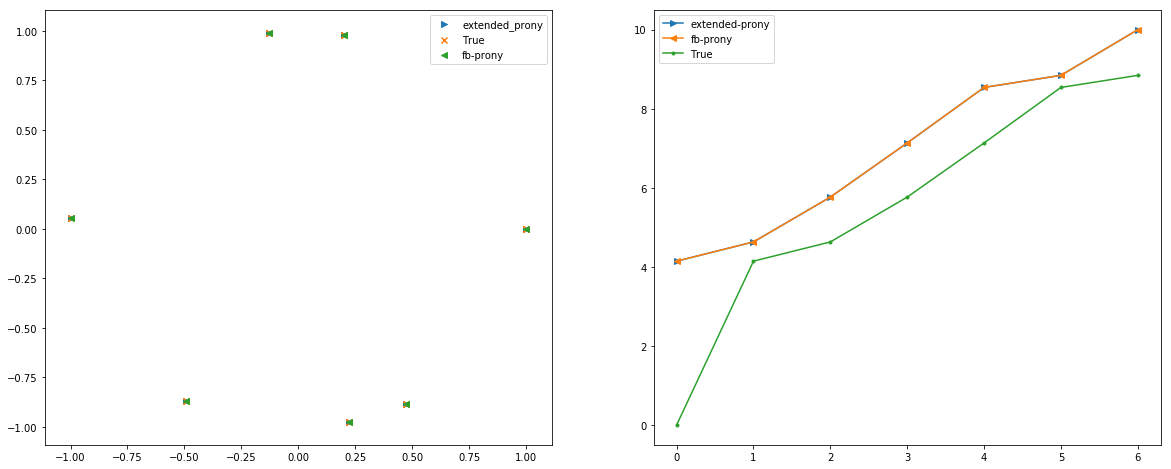

In [38]:
# Finding the pairwise distances based on the second order moments

feature = "cov"
K_dist = K*(K-1)/2 + 1
M_tilde = int(np.square(supp)) #2*K_dist
prony_mat, prony_vec  = extended_prony_matrix(K_dist, M_tilde, alpha, p_dist, delta, feature)
A = np.linalg.pinv(prony_mat).dot(prony_vec)
A = np.concatenate((np.array([[1]]),A),axis=0)

harm = np.roots(tuple(A.reshape(1,-1)[0]))
true_harm = np.exp(-2j*math.pi*np.square(delta*p_dist.reshape(1,-1)[0])/(M_tilde))
    
# using forward_backward prony matrix
prony_mat_f, prony_vec_f = forward_backward_prony_matrix(K_dist, M_tilde, alpha, p_dist, delta, feature)
B = np.linalg.pinv(prony_mat_f).dot(prony_vec_f)
B = np.concatenate((np.array([[1]]),B),axis=0)
harm_f = np.roots(tuple(B.reshape(1,-1)[0]))

# recovering the pairwise distances
p_dist_extended_prony = dist_finder(harm,M_tilde)
p_dist_fb_prony = dist_finder(harm_f,M_tilde)
   
plt.figure(num=None, figsize=(20, 8))
plt.subplot(121)
plt.scatter(np.real(harm),np.imag(harm),marker=">",label="extended_prony")
plt.scatter(np.real(true_harm), np.imag(true_harm),marker="x",label="True")
plt.scatter(np.real(harm_f), np.imag(harm_f),marker="<",label="fb-prony")
plt.legend()
plt.subplot(122)
plt.plot(np.sort(p_dist_extended_prony),marker=">", label="extended-prony")
plt.plot(np.sort(p_dist_fb_prony), marker = "<", label="fb-prony")
plt.plot(np.unique(np.sort(p_dist.reshape(1,-1)[0])),marker=".",label="True")
plt.legend()

print(np.square(p_dist)/M)

In [39]:
## Finding the corresponding weights for each harmonic
# based on the harmonics obtained from the distance from the origin
weight_mat, weight_vec = weight_mat_gen(K_dist,harm_f,alpha,p_dist,delta,M_tilde,"cov")
alpha_rec = np.linalg.pinv(weight_mat).dot(weight_vec)
alpha_rec = np.real(np.delete(alpha_rec,np.where(np.square(np.abs(harm_f-1.))<1e-5)))

weight_mat_o, weight_vec_o = weight_mat_gen(K,harm_fo,alpha,o_dist,delta,M,"mean")
alpha_rec_orig = np.linalg.pinv(weight_mat_o).dot(weight_vec_o)
     
tmp = np.real(alpha_rec_orig.dot(alpha_rec_orig.T))
alpha_rec_o = (np.triu(tmp)-np.diag(np.diag(tmp)))
alpha_rec_o = alpha_rec_o[alpha_rec_o>0]


The $\alpha$ recovered from the mean features exactly match the true one, although they are scrambled.

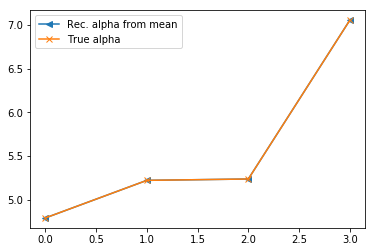

In [40]:
plt.figure()
plt.plot(np.sort(np.real(alpha_rec_orig),axis=0),marker='<',label='Rec. alpha from mean')
plt.plot(np.sort(alpha,axis=0),marker='x',label='True alpha')
plt.legend()
plt.show()

The problem of associating the lables to the pairwise distances can be posed as a problem in which the target is to recover a permutation matrix.

However, when I am trying to solve this optimization problem, the result does not comply with the constraints! I should take a deeper look at how the optimization is done.

In [307]:
# posing the problem as a least squares problem in order to solve for the weights
# defining the optimization problem in order to find the correct permutations

# definition of the bounds
lb = np.zeros((np.square(K_dist-1),1))
ub = np.ones((np.square(K_dist-1),1))
bounds = Bounds(0.,1.)

# definition of the linear constraints
G = lin_con_gen(K)
v_ones = np.ones((np.square(K_dist-1)))

x0 = np.random.rand((np.square(K_dist-1)))
linear_constraint = LinearConstraint(G,v_ones,v_ones)
cons = ([{'type': 'ineq', 'fun': lambda x: -x[i]**2 + x[i]} for i in range(len(lb))]+
        [{'type': 'ineq', 'fun': lambda x: -x[i]**2 + x[i]} for i in range(len(lb))]+
       [{'type':'eq', 'fun': cons_i, 'args': (i,G,)} for i in np.arange(6)])

res = minimize(opt_objective,x0,method='SLSQP',args=(alpha_rec_o,alpha_rec/2.),constraints=cons,bounds=bounds,options={'ftol':1e-9,'disp':True,'maxiter': 5000})
perm = np.reshape(res.x,(K_dist-1,K_dist-1))

# print res.x
print perm

7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.000377852801909
            Iterations: 33
            Function evaluations: 1299
            Gradient evaluations: 33
[[5.71716983e-02 3.35920274e-01 1.08470720e-01 4.44654070e-01
  2.46546204e-02 2.91286174e-02]
 [1.32404696e-11 5.13143671e-16 1.25988210e-11 1.00000000e+00
  5.21514260e-12 1.59186758e-11]
 [2.95664209e-02 6.41319253e-01 3.97034851e-02 2.54051811e-01
  2.06916654e-02 1.46673649e-02]
 [3.21835299e-02 5.47893067e-01 1.17156539e-01 2.69231445e-01
  1.67251490e-02 1.68102694e-02]
 [2.57059728e-12 1.00000000e+00 1.88781187e-15 1.55322186e-13
  4.29826202e-14 2.94134610e-16]
 [1.57422089e-02 7.98414489e-01 3.02940375e-02 1.32953615e-01
  1.22488455e-02 1.03468043e-02]]


In [295]:
print np.sum(G*res.x,axis=1)
print alpha_rec_o
print alpha_rec
print alpha

print cons

[1.         1.         1.         1.         1.         1.
 0.10086248 3.20470603 0.34328204 2.01447277 0.2304849  0.10619178]
[37.46216278 63.77026541 26.16700763 27.54840688 11.30400459 19.24233198]
[ 52.33401526  22.60800918  38.48466397 127.54053084  74.92432555
  55.09681358]
[[4.0228659 ]
 [6.84795556]
 [2.80993821]
 [9.31230713]]
[{'fun': <function cons_i at 0x121419e60>, 'args': (0, array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1.,

# How can we solve the above problem using MUSIC?
Note that the $Y$ matrices (the large matrices written on the left hand side of the prony equations) can be written as the following,

\begin{equation}
A(\mathbf{\lambda}) = 
  \begin{bmatrix}
    \lambda_1^0 & \lambda_2^0 & \cdots & \lambda_K^0 \\
    \lambda_1^1 & \lambda_2^1 & \cdots & \lambda_K^1 \\
    \lambda_1^2 & \lambda_2^2 & \cdots & \lambda_K^2 \\
    \vdots & \vdots & \cdots & \vdots \\
    \lambda_1^{M-1-K} & \lambda_2^{M-1-K} & \cdots & \lambda_K^{M-1-K} \\
  \end{bmatrix}
\end{equation}

\begin{equation}
G(\mathbf{\lambda}) = 
  \begin{bmatrix}
    \lambda_1^{K-1} & \lambda_2^{K-1} & \cdots & \lambda_K^{K-1} \\
    \lambda_1^{K-2} & \lambda_2^{K-2} & \cdots & \lambda_K^{K-2} \\
    \lambda_1^{K-3} & \lambda_2^{K-3} & \cdots & \lambda_K^{K-3} \\
    \vdots & \vdots & \cdots & \vdots \\
    \lambda_1^0 & \lambda_2^0 & \cdots & \lambda_K^0 \\
  \end{bmatrix}
\end{equation}

\begin{equation}
Y = A(\mathbf{\lambda}) \textrm{diag}(\alpha) G^T(\mathbf{\lambda})
\end{equation}

But why?
\begin{equation}
Y[m,n] = x[K-1-(n-m)] = \sum\limits_{k=1}^{K} \alpha_k \lambda_{k}^{K-1-(n-m)} = \sum\limits_{k=1}^{K} \lambda_{k}^{m} \alpha_k  \lambda_{k}^{K-1-n} = A(\mathbf{\lambda})[m,:] \textrm{diag}(\alpha) (G(\mathbf{\lambda})[n,:])^T
\end{equation}

Now, based on the fact that $A(\lambda)$ is full column rank and $\textrm{diag} \alpha G^T(\lambda)$ is full row rank, we have $R(A(\lambda)) = R(U_s) = R^{\perp}(U_n)$ where $U_s$/$U_n$ correspond to the left singular vectors that correspond to the non-zero/zero singular values. As $a(\mathbf{\theta}) = [\lambda^0 \lambda^1 ... \lambda^{M-K-1}]$ is in $R(A(\mathbf{\theta})) = R(U_s)$ for $\lambda = \lambda_1, \lambda_2, ..., \lambda_K$, this implies that,
\begin{equation}
a(\lambda_i) \perp R(U_n) \rightarrow \Vert U_n^H a(\lambda)\Vert = 0, \, \forall \lambda = \{\lambda_1,...,\lambda_K\} 
\end{equation}

In [93]:
# generating the A and G matrix
def mat_A_G(dist,M,K):
    A = np.zeros((M-K,K),dtype=complex)
    G = np.zeros((K,K),dtype=complex)
    for k in range(K):
        A[:,k] = np.exp(-2j*math.pi*np.square(delta*dist[k])*(np.arange(M-K))/(M))
        G[:,k] = np.exp(-2j*math.pi*np.square(delta*dist[k])*np.array(list(reversed(range(K))))/(M))
        
    return A, G

In [ ]:
feature = "mean"
prony_mat, prony_vec  = extended_prony_matrix(K, M, alpha, o_dist, delta, feature)
u, s, vh = np.linalg.svd(prony_mat, full_matrices=True)
print u.shape
print s

# lets generate A(lambda)
A = np.zeros((M-K,K),dtype=complex)
for k in range(K):
    A[:,k] = np.exp(-2j*math.pi*np.square(delta*o_dist[k])*(np.arange(M-K)+1)/(M))
u_A, s_A, _ = np.linalg.svd(A, full_matrices=True)
A, G = mat_A_G(o_dist,M,K)

temp = np.dot(A,np.dot(np.diag(np.squeeze(alpha,axis=1)),G.T))
print np.linalg.norm(temp-prony_mat)

print np.sum(np.conj(u_A[:,5])*A[:,1])
print s_A

# lets check whether a(theta) is in the range space of U_s
true_harm_o = np.exp(-2j*math.pi*np.square(delta*o_dist[1])*(np.arange(M-K)+1)/(M))

# Now lets find the null space of Un^H, for this purpose we use the root-MUSIC method
Un = u[:,K+1:]
V = np.dot(Un,np.conj(Un.T))

P = np.zeros((2*(M-K))-1,dtype=complex)
for i in range(M-K):
    for j in range(M-K):
        P[i-j+M-K-1] = P[i-j+M-K-1]+V[i,j]
        
music_roots = np.roots((P))
# print music_roots

# plotting the roots
true_o = np.exp(-2j*math.pi*np.square(delta*o_dist)/(M))
plt.figure()
plt.scatter(np.real(music_roots),np.imag(music_roots),label="MUSIC",marker=">",s=30)
plt.scatter(np.real(true_o), np.imag(true_o),label="True",marker="x",s=50,color='black')
plt.scatter(np.cos(np.linspace(0,2*math.pi,1000)),np.sin(np.linspace(0,2*math.pi,1000)),marker = ".", color='red',s=1)

# Recovering the geometry info using Hanjie's approach 

## generating the measurements

In [91]:
omega = np.linspace(0,2*math.pi/T,T-1)
# vec = np.concatenate((-vec[num_points:0:-1],vec))

ind_pos = np.array(np.where(omega>math.pi))

# the function that is convolved by the sum of complex exponentials

def G(x): 
    if x=0:
        return 0
    else:
        return (2./np.sqrt(-x))

/Users/monazehni/respos/Atomic_model/env/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126.]
[[0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.15470054+0.j         1.41421356+0.j
  2.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.14928939+0.11165672j 1.40747905+0.13785033j
  1.9903231 +0.19650439j]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.13310668+

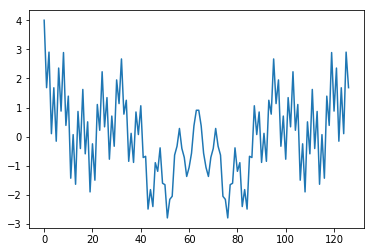

In [204]:
# generating the features exactly from the forward model
# pdb.set_trace()
o_dist = np.array([1,2,4,8])
T = np.prod(np.square(o_dist))

# discretizing the omega
# (it should not contain zero)
num_points = 100
omega = np.linspace(0,2*math.pi/T,T-1)
# vec = np.concatenate((-vec[num_points:0:-1],vec))

ind_pos = np.array(np.where(omega>math.pi))

# generating b
b = np.zeros((len(omega),1),dtype='complex')
b_times_G = np.zeros((len(omega),1),dtype='complex')

for omega_ind in range(len(omega)):
    for k in range(K):
        b[omega_ind,0] = b[omega_ind,0] + 1*np.exp(-2j*math.pi*np.square(delta*o_dist[k])*(omega[omega_ind])/len(omega))
    if omega[omega_ind]>np.floor(r_max**2)-1:
#         pdb.set_trace()
        b_times_G[omega_ind,0] = b[omega_ind,0] * G(omega[omega_ind]-len(omega))
        
# Generating the F^{-1} matrix
Omega = np.linspace(0,math.pi,200)
F = np.zeros((len(Omega),len(omega)),dtype='complex')

# generating the operator matrix
Q = np.zeros((len(Omega),len(omega)),dtype='complex')

for Omega_ind in range(len(Omega)):
    for omega_ind in range(len(omega)):
        F[Omega_ind,omega_ind] = np.exp(2j*math.pi*Omega[Omega_ind]*(omega[omega_ind])/len(omega))
        if omega[omega_ind]>np.floor(r_max**2)-1:
#             pdb.set_trace()
            Q[Omega_ind,omega_ind] = G(omega[omega_ind]-len(omega)) * np.exp(2j*math.pi*Omega[Omega_ind]*(omega[omega_ind])/len(omega))
            
        
        
# this is the measurement that we have
mu_hat = F.dot(b_times_G)
# pdb.set_trace()

# 
print(Q)
Q_cropped = Q[:,0:int(ind_pos[0][0])]
print(Q_cropped.shape)

# checking whether the forward model works
error = np.linalg.norm(Q.dot(b)-mu_hat)
print('The error is '+str(error))

plt.figure()
plt.plot(np.real(b))
plt.show()




## solving the optimization problem using alternating method

In [205]:
def Tmtx(data, K):
    """Construct convolution matrix for a filter specified by 'data'
    """
    return linalg.toeplitz(data[K::], data[K::-1])

def Rmtx(data, K, seq_len):
    """A dual convolution matrix of Tmtx. Use the commutativness of a convolution:
    a * b = b * c
    Here seq_len is the INPUT sequence length
    """
    col = np.concatenate(([data[-1]], np.zeros(seq_len - K - 1)))
    row = np.concatenate((data[::-1], np.zeros(seq_len - K - 1)))
    return linalg.toeplitz(col, row)

def dirac_recon_time(G, a, K, noise_level, b_true, max_ini=100, stop_cri='mse'):
    pdb.set_trace()
    compute_mse = (stop_cri == 'mse')
    M = G.shape[1]
    GtG = np.dot(G.conj().T, G)
    Gt_a = np.squeeze(np.dot(G.conj().T, a))

    max_iter = 50
    min_error = float('inf')
    # beta = linalg.solve(GtG, Gt_a)
    beta = np.linalg.lstsq(G, a, rcond=None)[0]
    print np.linalg.norm(G.dot(b_true)-a)
    beta = b_true
    
    # generate the matrix involving b that generates c
    # u need to use circ shift in order to generates the matrix that solves for C
        
    for ini in range(max_ini):
        print('Iteration = '+str(ini))
        cc = np.random.randn(K + 1) + 1j * np.random.randn(K + 1)
        c0 = cc.copy()
        b = b_true
        error_seq = np.zeros(max_iter)
        for loop in range(max_iter):
            # recovering c from b
            B1 = np.zeros((M+K,K),dtype='complex')
            b1 = np.zeros((M+K,1),dtype='complex')
            for i in range(M+K):
                b1[i,0] = -b[np.mod(i,M)]
                for u in range(K):
                        B1[i,u] = b[np.mod(i-u,M)]
            
#             pdb.set_trace()
            cc = np.linalg.pinv(B1).dot(b1)
            cc = np.concatenate(([[1.]],cc))
            
            # recovering b from c
            B2 = np.zeros((M+K,M),dtype='complex')
            for i in range(M+K):
                for u in range(M):
                    if ((i-u)%M)<=K:
                        B2[i,u] = cc[(i-u)%M,0]
                        
#             pdb.set_trace()
            A = np.concatenate((GtG,B2),axis=0)
            bb = np.concatenate((Gt_a,np.zeros((M+K,),dtype='complex')),axis=0)
            b = np.linalg.pinv(A).dot(bb)        
            
            error_seq[loop] = linalg.norm(a - np.dot(G, b))
            print(error_seq[loop])
        
        
    
    

#     Tbeta = Tmtx(beta, K)
#     rhs = np.concatenate((np.zeros(2 * M + 1), [1.]))
#     rhs_bl = np.concatenate((Gt_a, np.zeros(M - K)))

#     for ini in range(max_ini):
#         print('Iteration = '+str(ini))
#         c = np.random.randn(K + 1) + 1j * np.random.randn(K + 1)
#         c0 = c.copy()
#         error_seq = np.zeros(max_iter)
#         R_loop = Rmtx(c, K, M)

#         # first row of mtx_loop
#         mtx_loop_first_row = np.hstack((np.zeros((K + 1, K + 1)), Tbeta.conj().T,
#                                         np.zeros((K + 1, M)), c0[:, np.newaxis]))
#         # last row of mtx_loop
#         mtx_loop_last_row = np.hstack((c0[np.newaxis].conj(),
#                                        np.zeros((1, 2 * M - K + 1))))

#         for loop in range(max_iter):
#             mtx_loop = np.vstack((mtx_loop_first_row,
#                                   np.hstack((Tbeta, np.zeros((M - K, M - K)),
#                                              -R_loop, np.zeros((M - K, 1)))),
#                                   np.hstack((np.zeros((M, K + 1)), -R_loop.conj().T,
#                                              GtG, np.zeros((M, 1)))),
#                                   mtx_loop_last_row
#                                   ))

#             # matrix should be Hermitian symmetric
#             mtx_loop += mtx_loop.conj().T
#             mtx_loop *= 0.5
#             # mtx_loop = (mtx_loop + mtx_loop.conj().T) / 2.

#             c = np.linalg.solve(mtx_loop, rhs)[:K + 1]

#             R_loop = Rmtx(c, K, M)

#             mtx_brecon = np.vstack((np.hstack((GtG, R_loop.conj().T)),
#                                     np.hstack((R_loop, np.zeros((M - K, M - K))))
#                                     ))

#             # matrix should be Hermitian symmetric
#             mtx_brecon += mtx_brecon.conj().T
#             mtx_brecon *= 0.5
#             # mtx_brecon = (mtx_brecon + mtx_brecon.conj().T) / 2.

#             b_recon = np.linalg.solve(mtx_brecon, rhs_bl)[:M]

#             error_seq[loop] = linalg.norm(a - np.dot(G, b_recon))
#             print(error_seq[loop])
#             if error_seq[loop] < min_error:
#                 min_error = error_seq[loop]
#                 b_opt = b_recon
#                 c_opt = c
#             if min_error < noise_level and compute_mse:
#                 break
#         if min_error < noise_level and compute_mse:
#             break

    return b_opt, min_error, c_opt, ini

# you should root the polynomial with ceofficicnets c_opt

In [206]:
# recovering the point source model
print Q
noise_level = 0
u, s, v = np.linalg.svd(Q)
print(s)
b_opt, min_error, c_opt, _ = dirac_recon_time(Q, mu_hat, K, 0, b)

print(min_error)

[[0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.15470054+0.j         1.41421356+0.j
  2.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.14928939+0.11165672j 1.40747905+0.13785033j
  1.9903231 +0.19650439j]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.13310668+0.22226695j 1.38733967+0.27438777j
  1.96138603+0.39110722j]
 ...
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.12437871+0.26287989j 1.3114653 +0.5292058j
  1.71808086+1.02381549j]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.09368982+0.37037266j 1.25363579+0.65452066j
  1.60917589+1.18766702j]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 1.05275045+0.47439416j 1.18386662+0.77360185j
  1.48469908+1.34002561j]]
[5.40094867e+01 2.65874344e+01 1.22559040e+01 2.87757433e+00
 4.53451782e-01 5.60250850e-02 5.73176491e-03 5.00614229e-04
 3.81284269e-05 2.57291294e-06 1.55

6888.191995556498
6888.191995556272
6888.191995556449
6888.191995556317
6888.1919955563935
6888.1919955562735
Iteration = 6
6888.191995556287
6888.191995556421
6888.191995556315
6888.1919955564435
6888.191995556421
6888.191995556472
6888.191995556254
6888.191995556286
6888.191995556423
6888.191995556283
6888.191995556519
6888.191995556456
6888.191995556469
6888.191995556438
6888.191995556289
6888.191995556406
6888.191995556381
6888.191995556384
6888.191995556431
6888.1919955563635
6888.191995556301
6888.1919955564
6888.191995556268
6888.191995556355
6888.191995556365
6888.191995556348
6888.191995556357
6888.191995556269
6888.191995556383
6888.1919955563035
6888.191995556385
6888.191995556349
6888.191995556339
6888.191995556408
6888.191995556356
6888.19199555622
6888.191995556411
6888.191995556312
6888.191995556371
6888.191995556481
6888.191995556291
6888.191995556351
6888.191995556272
6888.191995556352
6888.191995556498
6888.191995556272
6888.191995556449
6888.191995556317
6888.1919955

KeyboardInterrupt: 